# Table of Contents
1. [Required Libraries](#required-libraries)
2. [Data Preprocessing](#data-preprocessing)
3. [Model Selection using KNN](#model-selection-using-KNN)
    1. [KNN Process](#process)
    2. [Evaluation and Analysis](#evaluation)
4. [Classifiers Comparison](#classifiers-comparison)
    1. [Comparison Process](#classi-process)
    2. [Performance Evaluation](#performance-evaluation)
5. [References](#references)

<a class="anchor" id="required-libraries"></a>
# 1. Required Libraries


In [1]:
import os
import cv2
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

<a id="data-preprocessing"></a>
# 2. Data Preprocessing

In [2]:
# Converting images to Grayscale and computing their corresponding Pixel Intensity Histograms

histograms = []
labels = []

for breed in os.listdir('./images/'):
    breed_path = os.path.join('./images', breed)
    for file in os.listdir(breed_path):
        file_path = os.path.join(breed_path, file)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            
        if image is not None:
            histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
            cv2.normalize(histogram, histogram)
            histogram = histogram.flatten()
            
            histograms.append(histogram)
            labels.append(breed)
        else:
            print(f'Warning: Could not read image file {file_path}')

histograms = np.array(histograms)
labels = np.array(labels)

# print(f'Histograms: {histograms}')
# print(f'Labels: {labels}')

# Standardizing the dataset

scaler = preprocessing.StandardScaler().fit(histograms)
scaled_histograms = scaler.transform(histograms)

# print(f'Scaled Histograms mean: {np.mean(scaled_histograms, axis=0)}')
# print(f'Scaled Histograms variance: {np.std(scaled_histograms, axis=0)}')

# Transforming labels to integers

labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(labels)

# Splitting the dataset into Training/Test (80/20)

x_train, x_test, y_train, y_test = train_test_split(scaled_histograms, labels, test_size=0.20, random_state=4)


<a id="model-selection-using-KNN"></a>
# 3. Model Selection using KNN

<a id="process"></a>
## 3.1 KNN Process


Standard Training Errors: [0.0, 0.3104651162790698, 0.3748062015503877, 0.40775193798449616, 0.43759689922480616, 0.4686046511627906]
Standard Validation Errors: [0.5472868217054263, 0.5689922480620155, 0.5503875968992248, 0.5348837209302325, 0.537984496124031, 0.5333333333333333]
Stratified Training Errors: [0.0, 0.3069767441860465, 0.3748062015503877, 0.4038759689922481, 0.43410852713178305, 0.46472868217054264]
Stratified Validation Errors: [0.5519379844961241, 0.5565891472868217, 0.5457364341085271, 0.5224806201550388, 0.5348837209302325, 0.5333333333333334]



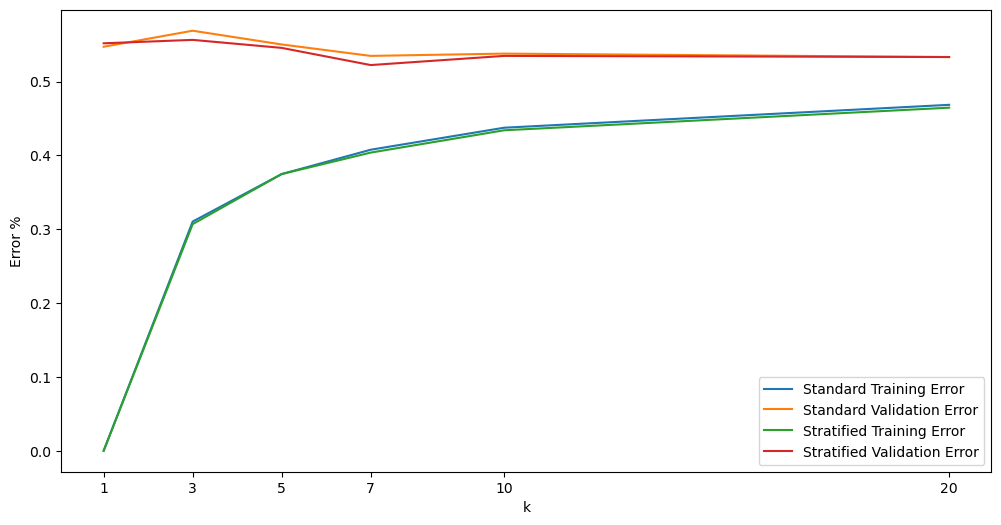

In [3]:
# Defining k-values for KNN (Number of neighbors)

k_values = [1, 3, 5, 7, 10, 20]

training_errors = []
validation_errors = []
skf_training_errors = []
skf_validation_errors = []

# Defining 5-Fold and Stratified 5-Fold cross-validation methods

kf = KFold(n_splits=5)
skf = StratifiedKFold(n_splits=5)

# Iterating over each k-value to evaluate the KNN classifier

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Computing training and validation errors for Standard 5-fold cross-validation
    cv_accuracy = cross_validate(knn, x_train, y_train, cv=kf, return_train_score=True)
    training_errors.append(1 - cv_accuracy['train_score'].mean())
    validation_errors.append(1 - cv_accuracy['test_score'].mean())
    
    # Computing training and validation errors for Stratified 5-fold cross-validation
    skf_cv_accuracy = cross_validate(knn, x_train, y_train, cv=skf, return_train_score=True)
    skf_training_errors.append(1 - skf_cv_accuracy['train_score'].mean())
    skf_validation_errors.append(1 - skf_cv_accuracy['test_score'].mean())


print(f'Standard Training Errors: {training_errors}\n'
      f'Standard Validation Errors: {validation_errors}\n'
      f'Stratified Training Errors: {skf_training_errors}\n'
      f'Stratified Validation Errors: {skf_validation_errors}\n')

# Plotting error curves

plt.figure(figsize=(12, 6))
plt.plot(k_values, training_errors, label='Standard Training Error')
plt.plot(k_values, validation_errors, label='Standard Validation Error')
plt.plot(k_values, skf_training_errors, label='Stratified Training Error')
plt.plot(k_values, skf_validation_errors, label='Stratified Validation Error')
plt.xticks(k_values)
plt.xlabel('k')
plt.ylabel('Error %')
plt.legend()
plt.show()


<a id="evaluation"></a>
## 3.2 Evaluation and Analysis

Here you will find:

* A summary of the k-values with the lowest errors for training and validation.
* An analysis of the model performance for k=1,3,5,7,10,20.
* An evaluation of the best k-value (based on the lowest mean Stratified validation error obtained in subsection 3.1) on the test Set

In [4]:
print(f'The k with the lowest mean error for the Standard Training error curve is: {k_values[np.argmin(training_errors)]}')
print(f'The k with the lowest mean error for the Standard Validation error curve is: {k_values[np.argmin(validation_errors)]}')
print(f'The k with the lowest mean error for the Stratified Training error curve is: {k_values[np.argmin(skf_training_errors)]}')
print(f'The k with the lowest mean error for the Stratified Validation error curve is: {k_values[np.argmin(skf_validation_errors)]}\n')

print('For k=1: The training errors are 0, which means it has complete accuracy, but the validation errors are very high. '
      'This indicates that the model is overfitting and has high complexity.')
print('For k=3: Both the training errors and validation errors increase, which means that the model is still complex and '
      'overfitting, but less so than when k=1.')
print('For k=5: The training errors keep increasing but the validation errors start to decrease. This suggests that increasing '
      'k is reducing overfitting, though the model is still complex and overfitting.')
print('For k=7: The training errors increase a bit less than for previous values of k, but the validation error for the '
      'stratified cross-validation is at its minimum value, while the validation error for the standard cross-validation decreases '
      'significantly. This could mean a balance between bias and variance, indicating the model is just complex enough.')
print('For k=10: Both the training and validation errors slightly increase, which means the model is starting to be too simple '
      'and beginning to underfit.')
print('For k=20: The training errors increase and the validation errors barely decrease, indicating the model is already too simple '
      'and less sensitive to the fluctuations in the training data, thus underfitting.')

### Now, let's evaluate the k with the lowest mean validation error from the Stratified 5-fold cross-Validation

best_k = k_values[np.argmin(skf_validation_errors)]

# Training the KNN Classifier with the best k-value

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)

# Predicting on the test set

ypred = knn.predict(x_test)

# Calculating the test error
test_error = 1 - accuracy_score(y_test, ypred)

print(f'The test error using the k with the lowest mean validation error ({best_k}) is: {test_error}')

The k with the lowest mean error for the Standard Training error curve is: 1
The k with the lowest mean error for the Standard Validation error curve is: 20
The k with the lowest mean error for the Stratified Training error curve is: 1
The k with the lowest mean error for the Stratified Validation error curve is: 7

For k=1: The training errors are 0, which means it has complete accuracy, but the validation errors are very high. This indicates that the model is overfitting and has high complexity.
For k=3: Both the training errors and validation errors increase, which means that the model is still complex and overfitting, but less so than when k=1.
For k=5: The training errors keep increasing but the validation errors start to decrease. This suggests that increasing k is reducing overfitting, though the model is still complex and overfitting.
For k=7: The training errors increase a bit less than for previous values of k, but the validation error for the stratified cross-validation is a

<a id="classifiers-comparison"></a>
# 4. Classifiers Comparison

<a id="classi-process"></a>
## 4.1. Comparison Process
This section details the steps involved in training and evaluating the Multi-layer Perceptron(MLP), Decision Tree, and Random Forest Classifiers.

C:\Users\aless\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\aless\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\aless\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\aless\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\aless\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

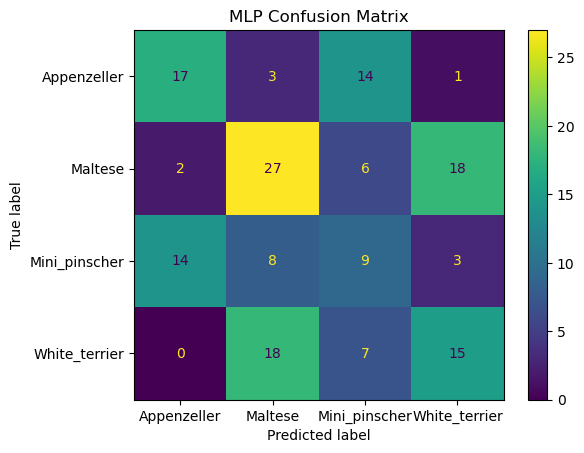

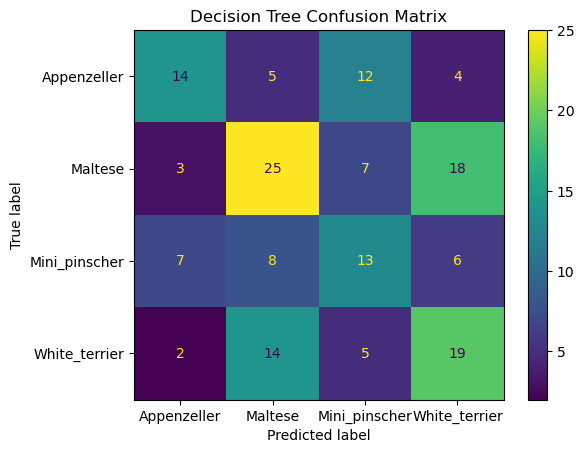

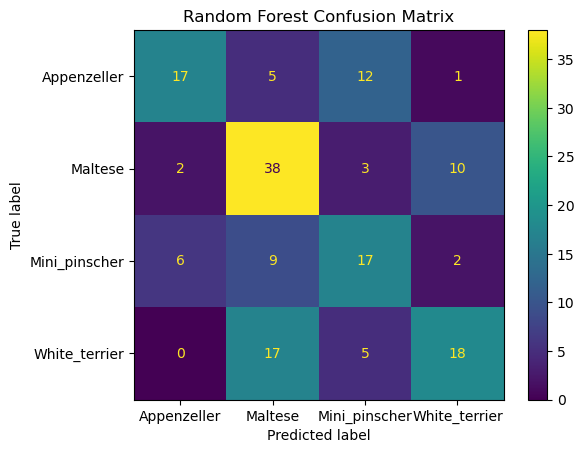

In [5]:
# Initializing Stratified K-Fold cross-validation with 5 splits

skf = StratifiedKFold(n_splits=5)

mlp_acc = []
tree_acc = []
rforr_acc = []

# Defining classifiers

mlp = MLPClassifier(hidden_layer_sizes = (10, 10, 10))
tree = DecisionTreeClassifier(max_depth=10)
rforr = RandomForestClassifier()

my_classifiers = [mlp, tree, rforr]
classi_names = ["MLP", "Decision Tree", "Random Forest"]
accuracies = [mlp_acc, tree_acc, rforr_acc]

# Performing Stratified K-Fold cross-validation for each classifier

for i in range(len(my_classifiers)):
    for train_index, val_index in skf.split(x_train, y_train):
        # Splitting the data into training and validation sets using the generated indices
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Fitting the classifier on the training fold
        my_classifiers[i].fit(x_train_fold, y_train_fold)
        
        # Predicting on the validation fold
        y_valpred = my_classifiers[i].predict(x_val_fold)
        accuracies[i].append(accuracy_score(y_val_fold, y_valpred))
    
    # Fitting the classifier on the entire Training set and predict on the Test set
        
    my_classifiers[i].fit(x_train, y_train)
    ypred = my_classifiers[i].predict(x_test)

    # Converting labels back to the original version ( We need this for plotting)

    breed_orig = labelencoder.inverse_transform(np.unique(y_test))
    
    # Plotting Confusion Matrix
    cm = confusion_matrix(y_test, ypred)
    cm_disp = ConfusionMatrixDisplay(cm, display_labels=breed_orig).plot()
    plt.title(classi_names[i] + ' Confusion Matrix')
    plt.show()

# Calculating accuracy on the Test set

mlp_acc_test = accuracy_score(y_test, mlp.predict(x_test))
tree_acc_test = accuracy_score(y_test, tree.predict(x_test))
rforr_acc_test = accuracy_score(y_test, rforr.predict(x_test))

# Calculating F1-score on the test set

mlp_f1 = f1_score(y_test, mlp.predict(x_test), average = 'weighted')
tree_f1 = f1_score(y_test, tree.predict(x_test), average = 'weighted')
rforr_f1 = f1_score(y_test, rforr.predict(x_test), average = 'weighted')


<a id="performance-evaluation"></a>
## 4.2. Performance Evaluation


In [6]:
# Best Clasifier evaluation

# Best method based on the confusion matrices:
print('Based on the confusion matrices plotted, the one that shows the most True Positives and the least False Positives/Negatives is the one plotted using the Random Forest classifier.\n')

# Best method based on the mean validation accuracies from the 5-fold cross-validation
print('The mean validation accuracies for the classifiers are:')
print(f'MLP Classifier: {np.mean(mlp_acc):.4f}')
print(f'Decision Tree Classifier: {np.mean(tree_acc):.4f}')
print(f'Random Forest Classifier: {np.mean(rforr_acc):.4f}')
print('Based on the mean validation accuracies, the best one is the Random Forest Classifier.\n')

# Performance Summary on the test set

# Accuracies:
print('The accuracy on the test set for the classifiers is:')
print(f'MLP Classifier: {mlp_acc_test:.4f}')
print(f'Decision Tree Classifier: {tree_acc_test:.4f}')
print(f'Random Forest Classifier: {rforr_acc_test:.4f}\n')

# F-Measure:
print('The F-measure on the test set for the classifiers is:')
print(f'MLP Classifier: {mlp_f1:.4f}')
print(f'Decision Tree Classifier: {tree_f1:.4f}')
print(f'Random Forest Classifier: {rforr_f1:.4f}')

Based on the confusion matrices plotted, the one that shows the most True Positives and the least False Positives/Negatives is the one plotted using the Random Forest classifier.

The mean validation accuracies for the classifiers are:
MLP Classifier: 0.4589
Decision Tree Classifier: 0.4357
Random Forest Classifier: 0.5271
Based on the mean validation accuracies, the best one is the Random Forest Classifier.

The accuracy on the test set for the classifiers is:
MLP Classifier: 0.4198
Decision Tree Classifier: 0.4383
Random Forest Classifier: 0.5556

The F-measure on the test set for the classifiers is:
MLP Classifier: 0.4203
Decision Tree Classifier: 0.4397
Random Forest Classifier: 0.5519


<a id="references"></a>
# 5. References

## 5.1. Dataset

The dataset used for this project was obtained from:

Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao, and Li Fei-Fei, "Stanford Dogs Dataset", 2011, http://vision.stanford.edu/aditya86/StanfordDogs/


## 5.2. Knowledge Resources

1. scikit-learn, "KFold", https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
2. scikit-learn, "StratifiedKFold", https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
3. scikit-learn, "MLPClassifier", https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
4. scikit-learn, "DecisionTeeClassifier", https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html
5. scikit-learn, "RandomForestClassifier", https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html
6. scikit-learn, "ConfusionMatrixDisplay", https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
7. scikit-learn, "f1_score", https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.f1_score.html
8. Towards Data Science (Sarang Narkhede), "Understanding Confusion Matrix", 2018, https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62